# Project 4
# 整合DDPM和DIP技術
## 使用DIP來加速DDPM
將DIP加在DDPM的backward端，以加速過程

## git clone dip的文件

In [1]:
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (155/155), done.


## 安裝diffusers(ddpm)

In [2]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.7 MB/s eta 0:00:00


## 準備所有需要的library

In [14]:
import torch
from diffusers import DDPMScheduler
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.optim
from models import get_net
from utils.inpainting_utils import np_to_torch, torch_to_np, np_to_pil
import os

## 創建保存目錄

In [4]:
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('restored_images', exist_ok=True)

## DDPM forward部分
加載圖片并且為其用上mask\
這裏使用unsplash上下載的圖片作爲輸入\
將照片大小調整為 1007x800

In [5]:
# 加載圖像用的function
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((1007,800)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

# 展示圖片用的function
def show_image(tensor, title='Image'):
    image = tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    plt.imshow((image * 0.5) + 0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [6]:
# 加載圖片
image_path = '/content/p4.jpg'
clean_image = load_image(image_path).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

這裏在DDPMScheduler中選擇timesteps=500\
不能夠太多，不然噪聲太多不符合DIP的輸入

In [12]:
# 定义DDPM调度器
noise_scheduler = DDPMScheduler(num_train_timesteps=800)

# 生成噪聲圖像
timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (clean_image.shape[0],), device=clean_image.device).long()
noisy_images = noise_scheduler.add_noise(clean_image, torch.randn_like(clean_image), timesteps)

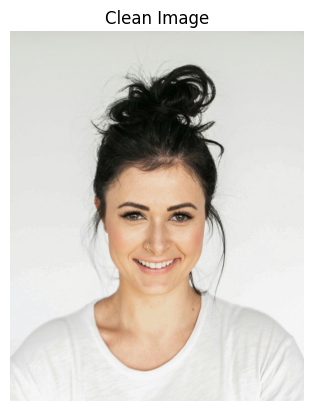

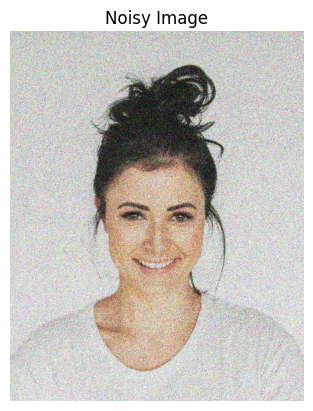

In [13]:
# 顯示圖片
show_image(clean_image, 'Clean Image')
show_image(noisy_images, 'Noisy Image')

## 定義PSNR function作爲評估指標

In [9]:
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(1.0 / math.sqrt(mse))
    return psnr

## 下半部分
### 使用DIP取代DDPM backward的部分

In [15]:

# 定义DIP模型
net = get_net(3, 'skip', 'reflection', n_channels=3,
              skip_n33d=64, skip_n33u=64, skip_n11=2,
              num_scales=3, upsample_mode='bilinear').to(clean_image.device)
mse = torch.nn.MSELoss().to(clean_image.device)

# 將噪聲圖像轉換為DIP模型輸入格式
noisy_image_np = torch_to_np(noisy_images)
noisy_image_var = np_to_torch(noisy_image_np).to(clean_image.device)

# 初始化DIP模型输入
net_input = torch.randn_like(noisy_image_var).detach().to(clean_image.device)

# DIP訓練循環參數設置
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
num_iter = 1000 # 迭代次數
save_iter = 50 # 每50步保存一次

# 恢復訓練設定
start_iter = 0
checkpoint_path = 'checkpoints/latest_checkpoint.pth'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_iter = checkpoint['iteration']
    net_input = checkpoint['net_input']

Iteration 0/1000, Loss: 0.4016337990760803, PSNR: 6.060419797230697


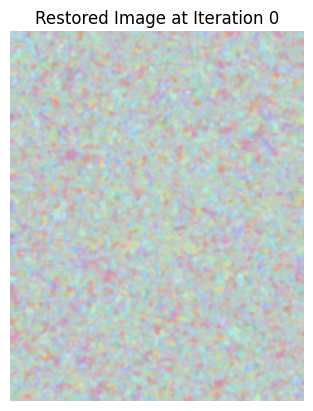

Iteration 50/1000, Loss: 0.2504180669784546, PSNR: 11.783722041004015


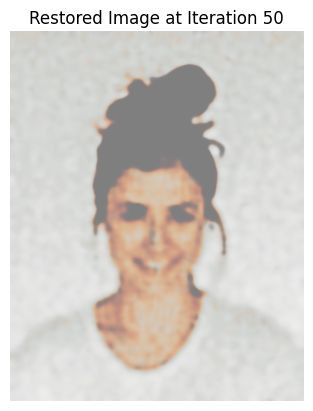

Iteration 100/1000, Loss: 0.2491629421710968, PSNR: 11.861267540622059


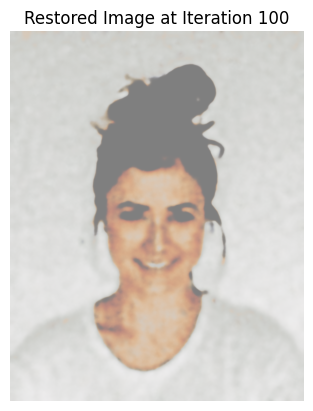

Iteration 150/1000, Loss: 0.24834652245044708, PSNR: 11.913610884148087


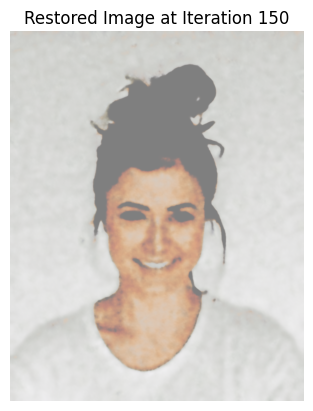

Iteration 200/1000, Loss: 0.24783717095851898, PSNR: 11.92938956691841


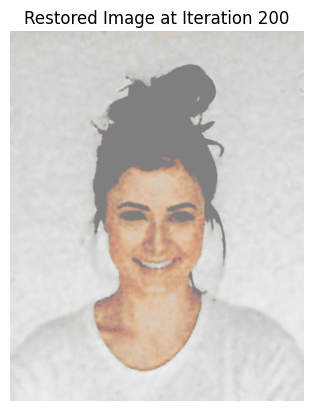

Iteration 250/1000, Loss: 0.24727927148342133, PSNR: 11.933626410523326


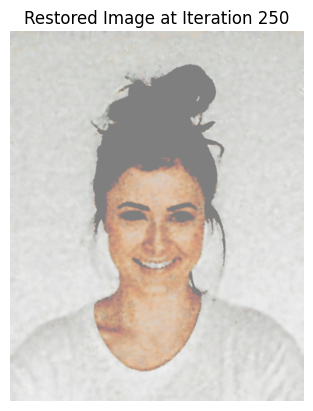

Iteration 300/1000, Loss: 0.24677951633930206, PSNR: 11.917757879131656


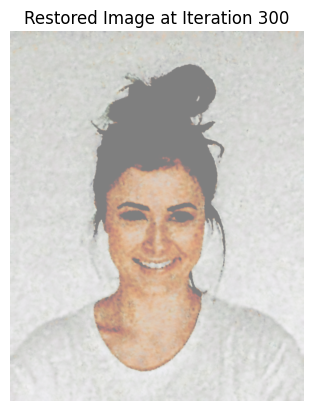

Iteration 350/1000, Loss: 0.2461363673210144, PSNR: 11.906676224534941


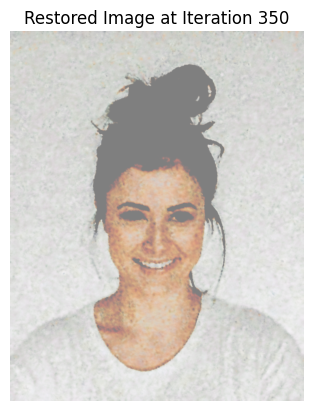

Iteration 400/1000, Loss: 0.24532248079776764, PSNR: 11.862071288587321


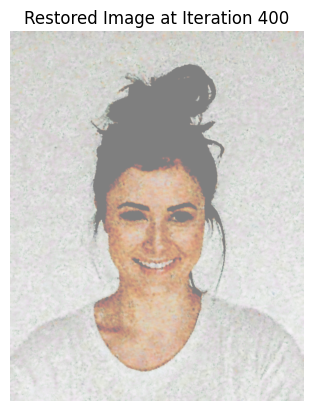

Iteration 450/1000, Loss: 0.24480308592319489, PSNR: 11.826558073716317


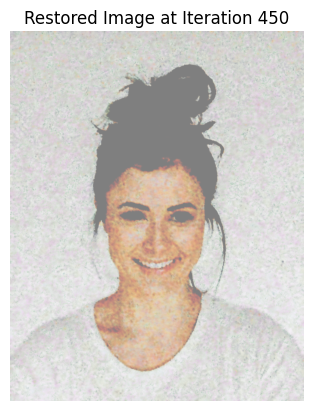

Iteration 500/1000, Loss: 0.24345210194587708, PSNR: 11.758288804966972


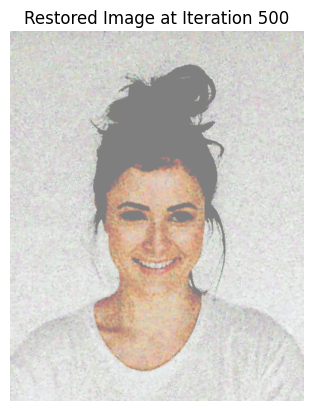

Iteration 550/1000, Loss: 0.24273739755153656, PSNR: 11.697462279954557


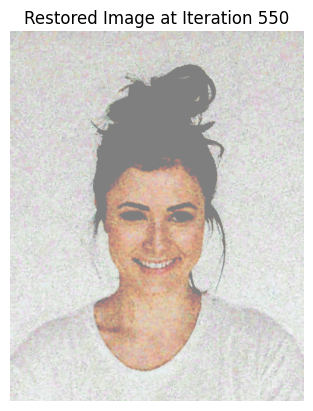

Iteration 600/1000, Loss: 0.24127735197544098, PSNR: 11.608103624634744


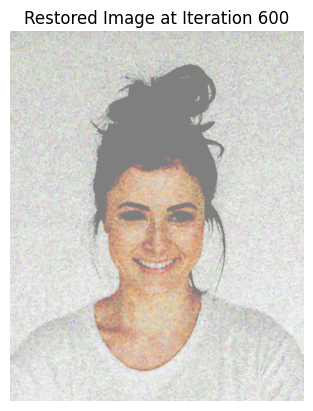

Iteration 650/1000, Loss: 0.24038350582122803, PSNR: 11.470200821196974


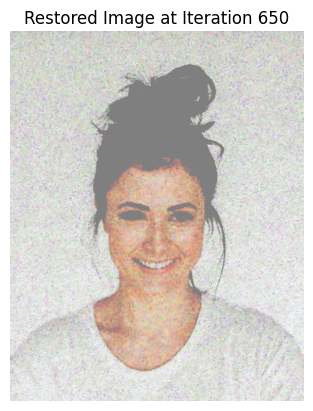

Iteration 700/1000, Loss: 0.23914644122123718, PSNR: 11.411820269420282


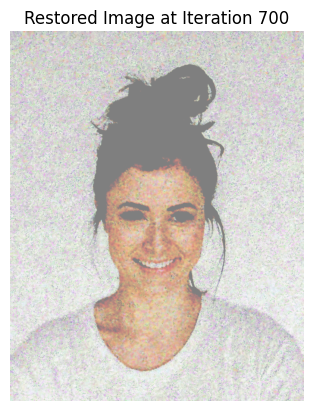

Iteration 750/1000, Loss: 0.23878751695156097, PSNR: 11.31879862990691


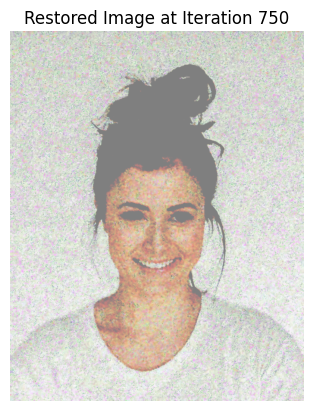

Iteration 800/1000, Loss: 0.23690222203731537, PSNR: 11.331477637923374


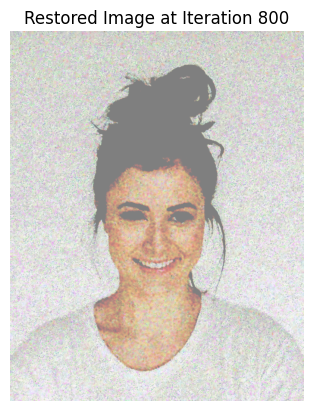

Iteration 850/1000, Loss: 0.23600217700004578, PSNR: 11.222441264454858


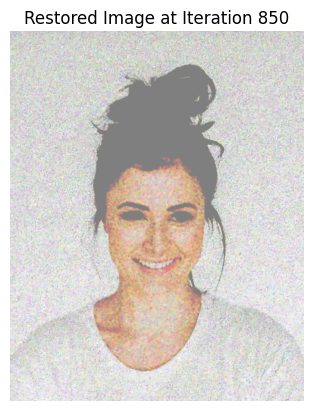

Iteration 900/1000, Loss: 0.2349921315908432, PSNR: 11.19049732922209


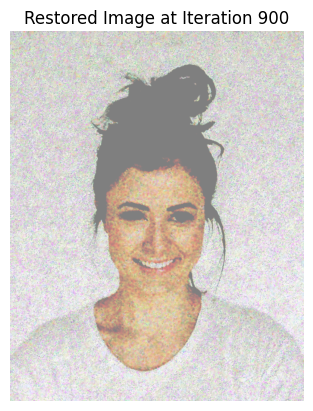

Iteration 950/1000, Loss: 0.2334456741809845, PSNR: 11.164845232935217


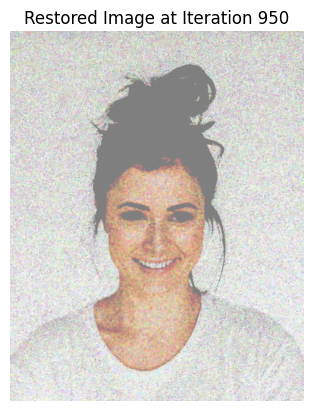

In [16]:
# 訓練過程
for i in range(num_iter+1):
    optimizer.zero_grad()
    out = net(net_input)
    loss = mse(out, noisy_image_var)
    loss.backward()
    optimizer.step()

    if i % save_iter == 0:
        psnr = calculate_psnr(out, clean_image) # 計算psnr
        print(f"Iteration {i}/{num_iter}, Loss: {loss.item()}, PSNR: {psnr}") # show iteration和psnr

        # 保存模型狀態
        torch.save({
            'iteration': i,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'net_input': net_input
        }, checkpoint_path)

        # 保存當前圖片
        restored_image = torch_to_np(out)
        restored_image_pil = np_to_pil(restored_image)
        restored_image_pil.save(f'restored_images/restored_image_{i}.png')

        # 顯示當前圖片
        show_image(torch.tensor(restored_image).unsqueeze(0), f'Restored Image at Iteration {i}')

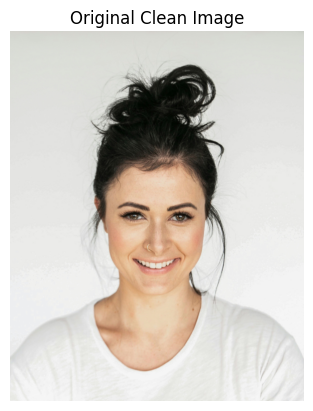

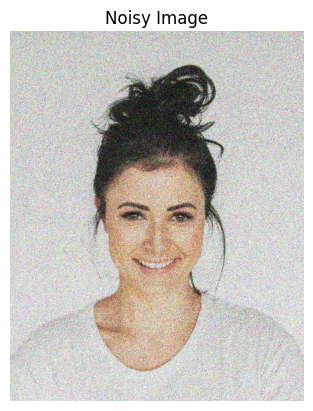

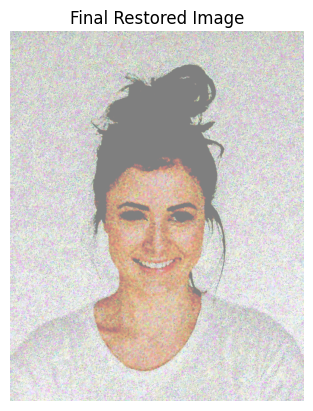

In [17]:
# 最终保存修复后的图像
restored_image = torch_to_np(net(net_input))
show_image(clean_image, 'Original Clean Image')
show_image(noisy_images, 'Noisy Image')
show_image(torch.tensor(restored_image).unsqueeze(0), 'Final Restored Image')